# Estimation paramétrique univariée

# Import des outils / jeu de données

In [77]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import stats
from scipy.stats import expon, kstest, lognorm, weibull_min

from src.modelisation.univariate.non_parametric.models import create_survival_models
from src.modelisation.univariate.parametric.models import create_models
from src.modelisation.univariate.parametric.plot import (
    plot_hazard_estimation,
    plot_hazard_estimations,
    plot_survival_estimation,
    plot_survival_estimations,
)
from src.utils import init_notebook

In [2]:
init_notebook()

# Données

In [3]:
df = pd.read_csv(
    "data/kickstarter_1.csv",
    parse_dates=True,
)

In [4]:
event_times = df["day_succ"]
event_observed = df["Status"]

event_times_no_censoring = df["day_succ"][df["Status"] == 1]
event_observed_no_censoring = df["Status"][df["Status"] == 1]
df_video = df[df["has_video"] == 1].copy()
df_no_video = df[df["has_video"] == 0].copy()

t_video = df_video["day_succ"]
o_video = df_video["Status"]

t_no_video = df_no_video["day_succ"]
o_no_video = df_no_video["Status"]

In [5]:
models = create_models()

# Tests statistiques sur les distributions

## Histogrammes

Text(0.5, 0, 'Nombre de jours avant le succès du projet')

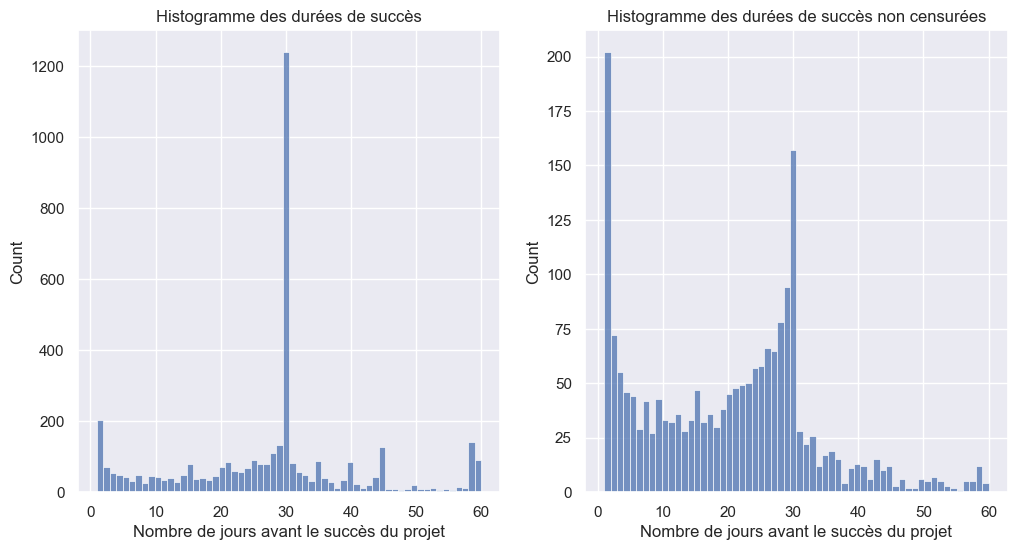

In [67]:
_, axs = plt.subplots(1, 2, figsize=(12, 6))

sns.histplot(event_times, ax=axs[0], bins=60)
axs[0].set_title("Histogramme des durées de succès")
axs[0].set_xlabel("Nombre de jours avant le succès du projet")

sns.histplot(event_times_no_censoring, ax=axs[1], bins=60)
axs[1].set_title("Histogramme des durées de succès non censurées")
axs[1].set_xlabel("Nombre de jours avant le succès du projet")

A première vue, la variable aléatoire de la durée s'écoulant avant le succès du projet ne suit pas une loi particulière.  

# Tests

Le test bilatéral de Kolmogorov-Smirnov, implémenté dans *scipy*, teste les hypothèse suivantes:  

$H_0: F(t) = G(t), \hspace{10px} \forall t$  
$H_1: F(t) \neq G(t), \hspace{10px} \forall t$ 

In [107]:
mean = np.mean(event_times)
std = np.std(event_times)

ks_norm, p_value_norm = kstest(
    rvs=event_times,  # Random variable to test
    cdf=stats.norm.cdf,  # Reference CDF
    args=(mean, std),  # Reference distribution parameters
)

print(f"Gaussian distribution p-value = {p_value_norm}")

Gaussian distribution p-value = 7.382711171697777e-103


In [108]:
ks_weibull, p_value_weibull = kstest(
    rvs=event_times,  # Random variable to test
    cdf=stats.weibull_min.cdf,  # Reference CDF
    args=(1.5,),  # Reference distribution parameters
)

print(f"Weibull distribution p-value = {p_value_weibull}")

Weibull distribution p-value = 0.0


In [109]:
log_mean = np.log(mean)
log_std = np.log(std)

ks_lognorm, p_value_lognorm = kstest(
    rvs=event_times,  # Random variable to test
    cdf=stats.lognorm.cdf,  # Reference CDF
    args=(1,),  # Reference distribution parameters
)

print(f"Log-normal distribution p-value = {p_value_lognorm}")

Log-normal distribution p-value = 0.0


In [110]:
ks_gamma, p_value_gamma = kstest(
    rvs=event_times,  # Random variable to test
    cdf=stats.gamma.cdf,  # Reference CDF
    args=(1,),  # Reference distribution parameters
)

print(f"Gamma distribution p-value = {p_value_gamma}")

Gamma distribution p-value = 0.0


Comme attendu, la fonction de survie ne suit pas une loi particulière.

# Fonction de survie

## Modèles paramétriques

In [6]:
# Génération de données selon la loi de Weibull
np.random.seed(42)
data = df["day_succ"]

# Test de Kolmogorov-Smirnov
ks_statistic, p_value = kstest(data, "weibull_min", args=(1.5,))

# Test de Kolmogorov-Smirnov
ks_statistic_exp, p_value_exp = kstest(data, "expon", args=(0, 1))

ks_statistic_lognorm, p_value_lognorm = kstest(
    data, "lognorm", args=(0.954, 0, np.exp(0))
)


print(f"KS test for Weibull\nStatistic: {ks_statistic}, P-value: {p_value}")
print("")
print(f"KS test for exponential\n{ks_statistic_exp}, P-value: {p_value_exp}")
print("")
print(f"KS test for lognormal\n{ks_statistic_lognorm}, P-value: {p_value_lognorm}")

KS test for Weibull
Statistic: 0.9288334267706474, P-value: 0.0

KS test for exponential
0.9032021727613936, P-value: 0.0

KS test for lognormal
0.8710483180388587, P-value: 0.0


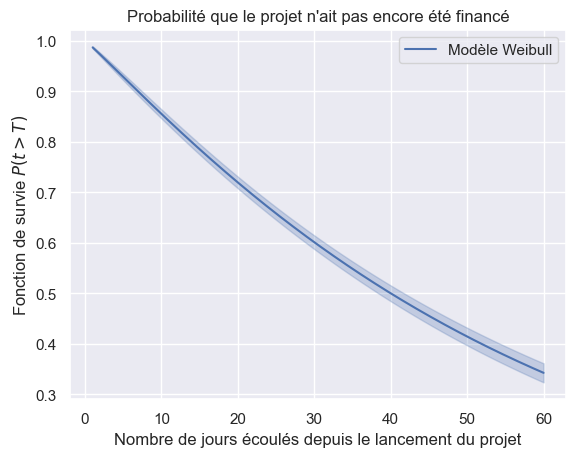

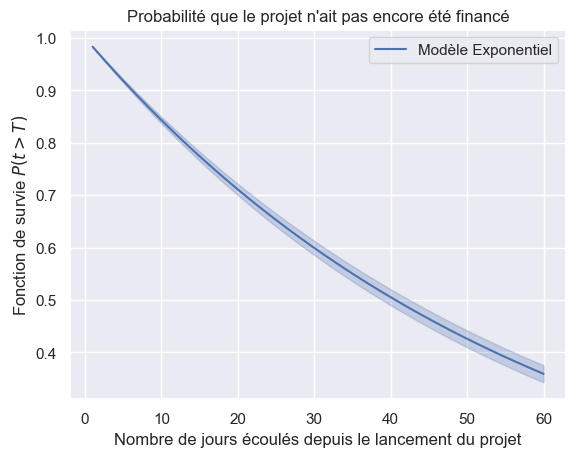

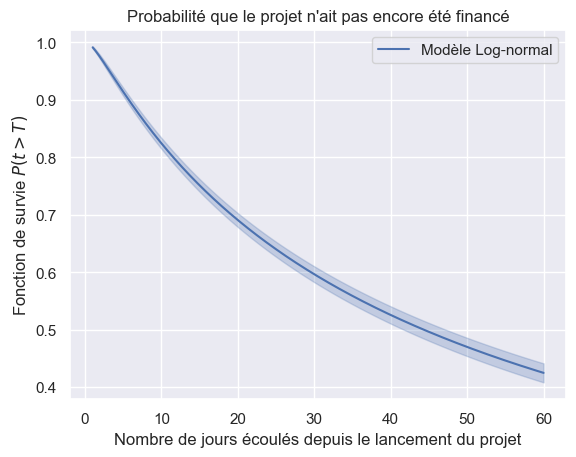

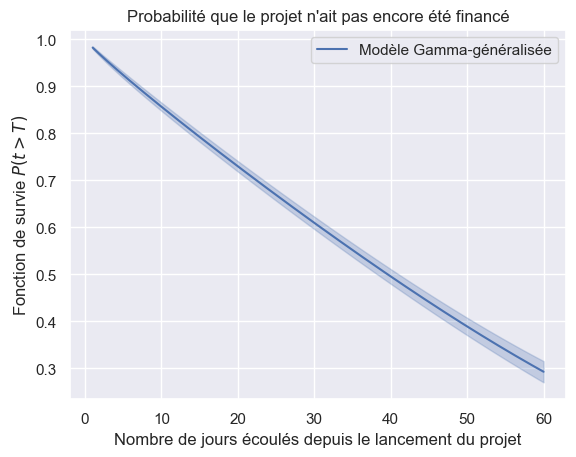

In [7]:
plot_survival_estimations(models, event_times, event_observed)

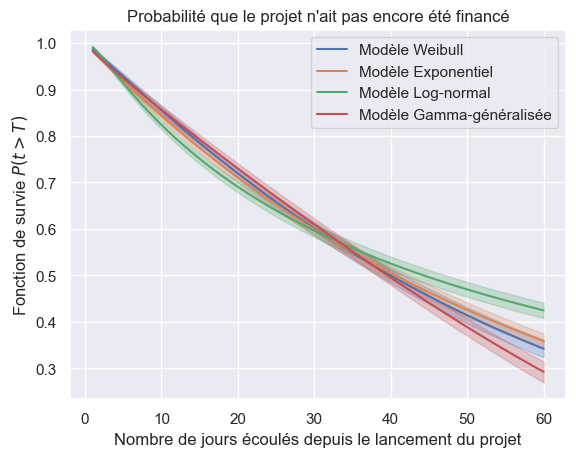

In [8]:
# todo tracer kaplam meier et test de logrank
plot_survival_estimations(models, event_times, event_observed, same_plot=True)

## Impact de la censure

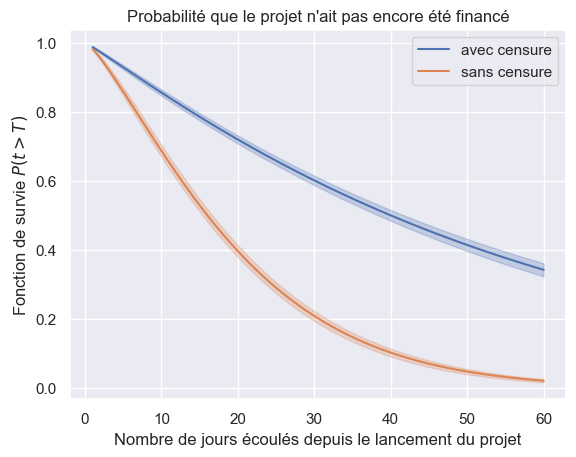

In [9]:
plot_survival_estimation(models["Weibull"], event_times, event_observed, "avec censure")
plot_survival_estimation(
    models["Weibull"],
    event_times_no_censoring,
    event_observed_no_censoring,
    "sans censure",
)

## Comparaison avec modèles non-paramétriques

In [10]:
km = create_survival_models()["Kaplan-Meier"]

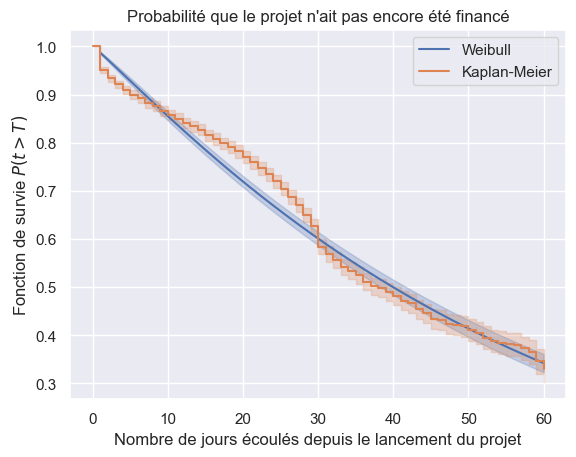

In [11]:
plot_survival_estimation(models["Weibull"], event_times, event_observed, "Weibull")
plot_survival_estimation(km, event_times, event_observed, "Kaplan-Meier")

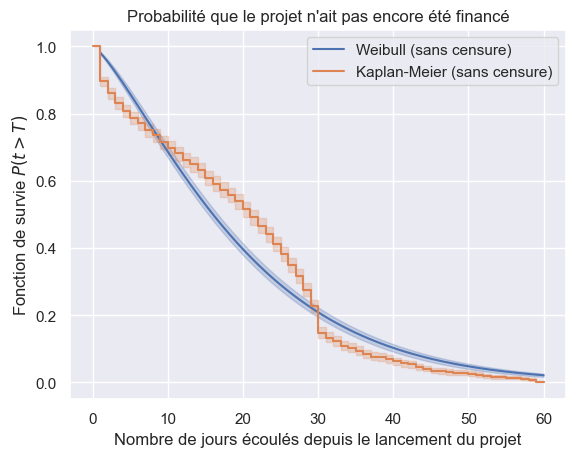

In [12]:
plot_survival_estimation(
    models["Weibull"],
    event_times_no_censoring,
    event_observed_no_censoring,
    "Weibull (sans censure)",
)
plot_survival_estimation(
    km,
    event_times_no_censoring,
    event_observed_no_censoring,
    "Kaplan-Meier (sans censure)",
)

## Co-variables

### Vidéo de présentation

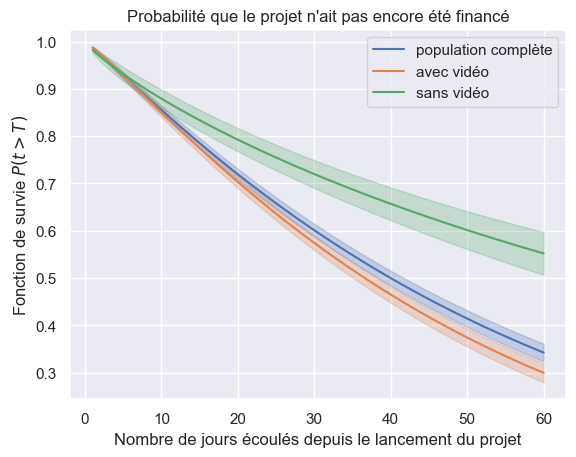

In [13]:
plot_survival_estimation(
    models["Weibull"], event_times, event_observed, "population complète"
)
plot_survival_estimation(models["Weibull"], t_video, o_video, "avec vidéo")
plot_survival_estimation(models["Weibull"], t_no_video, o_no_video, "sans vidéo")

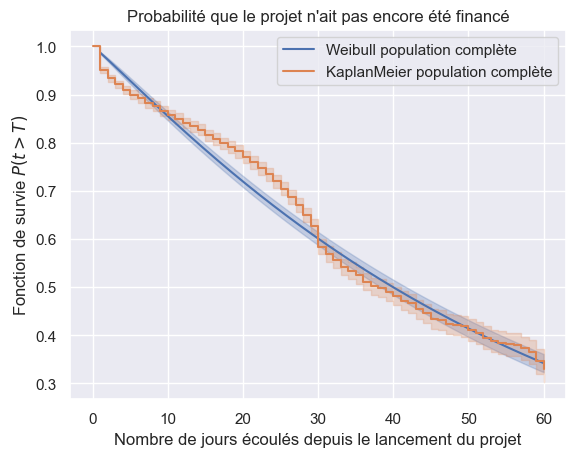

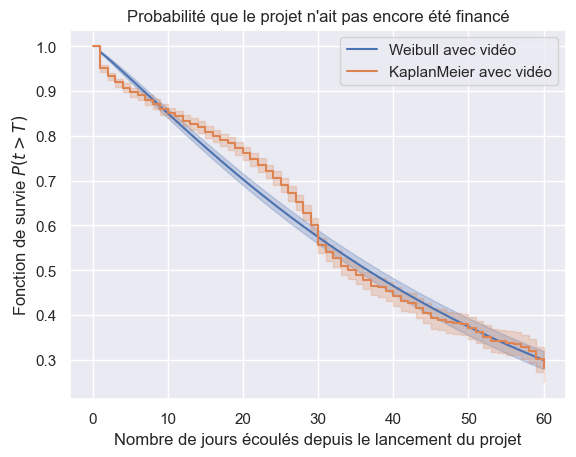

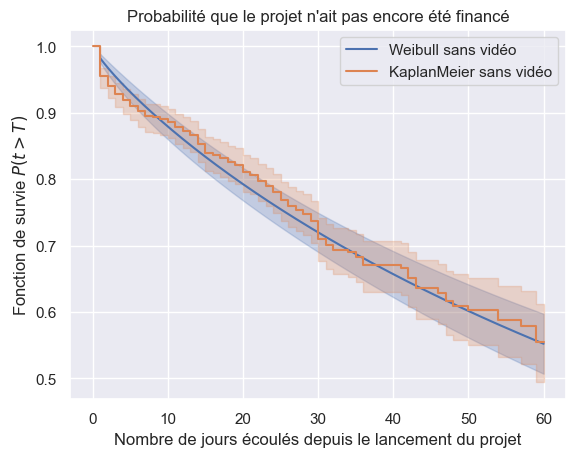

In [14]:
for model in (models["Weibull"], km):
    name = model.__class__.__name__.replace("Fitter", "")
    plot_survival_estimation(
        model, event_times, event_observed, f"{name} population complète"
    )
plt.show()
for model in (models["Weibull"], km):
    name = model.__class__.__name__.replace("Fitter", "")
    plot_survival_estimation(model, t_video, o_video, f"{name} avec vidéo")


plt.show()
for model in (models["Weibull"], km):
    name = model.__class__.__name__.replace("Fitter", "")
    plot_survival_estimation(model, t_no_video, o_no_video, f"{name} sans vidéo")

# Fonction de risque

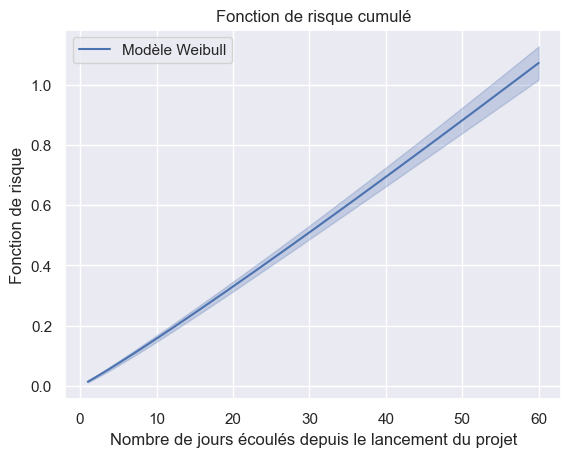

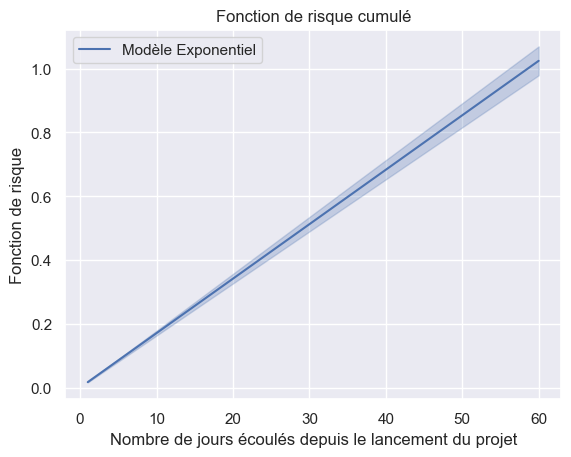

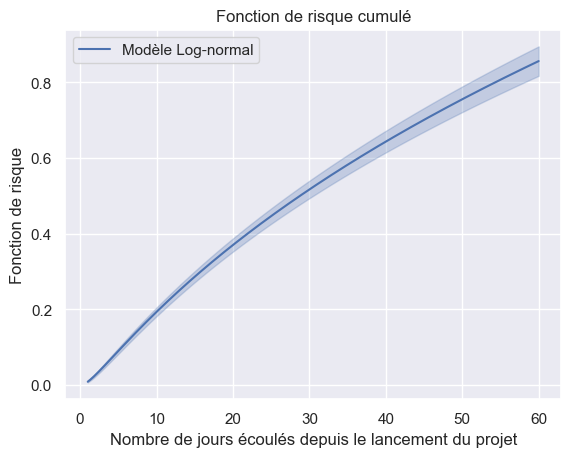

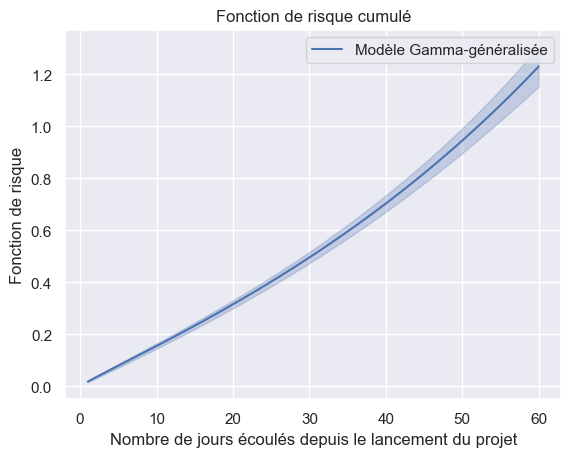

In [15]:
plot_hazard_estimations(models, event_times, event_observed)

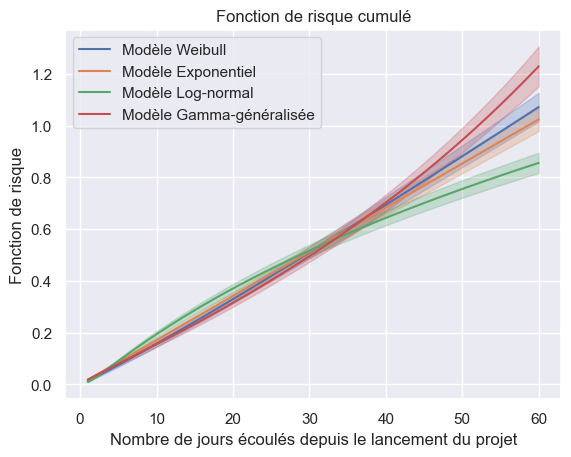

In [16]:
plot_hazard_estimations(models, event_times, event_observed, same_plot=True)

## Impact de la censure

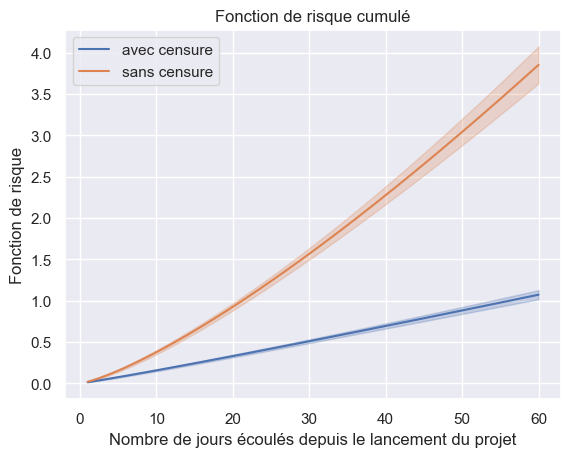

In [17]:
plot_hazard_estimation(models["Weibull"], event_times, event_observed, "avec censure")
plot_hazard_estimation(
    models["Weibull"],
    event_times_no_censoring,
    event_observed_no_censoring,
    "sans censure",
)

## Co-variables

### Vidéo de présentation

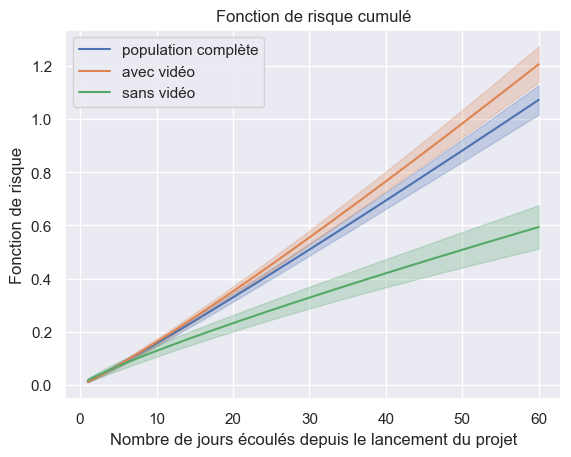

In [18]:
plot_hazard_estimation(
    models["Weibull"], event_times, event_observed, "population complète"
)
plot_hazard_estimation(models["Weibull"], t_video, o_video, "avec vidéo")
plot_hazard_estimation(models["Weibull"], t_no_video, o_no_video, "sans vidéo")